In [1]:
import numpy as np
import torch 
from model import PINNs
import pandas as pd
from utils import charge_data
import json
import matplotlib.pyplot as plt
from model import PINNs
from utils import charge_data
import json
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
import numpy as np
import time as time
import pandas as pd
from constants import DICT_CASE, DICT_Y0, PARAM_ADIM
from geometry import RectangleWithoutCylinder

In [2]:
folder_name = "12_huge_rnn"
epoch = "epoch1000"

In [3]:
param_adim = {"V": 1.0, "L": 0.025, "rho": 1.2}

In [4]:
with open("results/" + folder_name + "/hyper_param.json", "r") as file:
    hyper_param = json.load(file)
model = PINNs(hyper_param)
checkpoint = torch.load(
    "results/" + folder_name + "/" + epoch + "/" + "model_weights.pth",
    map_location=torch.device("cpu"),
)
model.load_state_dict(checkpoint["model_state_dict"])


<All keys matched successfully>

In [5]:
with open('results/'+folder_name+'/mean_std.json') as file: 
    mean_std = json.load(file)

In [6]:
def plot_flow(
    x,
    y,
    t,
    norme_vitesse_data,
    norme_vitesse_predict,
    name_file,
    fps=7,
    title="Norme vitesse",
):
    # Créer une figure et des axes
    # Ajuster la taille de la figure
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Déterminer les valeurs min et max pour la colormap
    vmin = min(np.min(norme_vitesse_data), np.min(norme_vitesse_predict))
    vmax = max(np.max(norme_vitesse_data), np.max(norme_vitesse_predict))

    # Initialiser les cartes de chaleur
    indices = np.where(t == np.min(t))
    c1 = ax[0].tripcolor(
        x[indices],
        y[indices],
        norme_vitesse_data[indices],
        shading="gouraud",
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
    )
    c2 = ax[1].tripcolor(
        x[indices],
        y[indices],
        norme_vitesse_predict[indices],
        shading="gouraud",
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
    )

    ax[0].set_title("Data")


    ax[1].set_title("Predictions")
    ax[0].set_xticks([])  # Enlever les valeurs de l'axe x
    ax[0].set_yticks([])  # Enlever les valeurs de l'axe y
    ax[1].set_xticks([])  # Enlever les valeurs de l'axe x
    ax[1].set_yticks([])  # Enlever les valeurs de l'axe y


    # Ajouter une barre de couleur
    cbar = fig.colorbar(c1, ax=ax, orientation="vertical", label=f"{title}")

    # Fonction d'initialisation
    def init():
        return c1, c2

    # Fonction d'animation
    def update(frame):
        print(frame)
        time = list(set(t))
        time.sort()
        indices = np.where(t == time[frame])

        # Mettre à jour la première carte de chaleur
        c1.set_array(norme_vitesse_data[indices].flatten())
        ax[0].set_title("Data", fontsize=15, fontweight='bold')

        # Mettre à jour la deuxième carte de chaleur
        c2.set_array(norme_vitesse_predict[indices].flatten())
        ax[1].set_title("Predictions", fontsize=15, fontweight='bold')

        # Titre général
        plt.suptitle(f"{title} at t={time[frame]:.2f}", fontsize=15)

        return c1, c2

    # Créer l'animation
    ani = FuncAnimation(
        fig, update, frames=len(set(t)), init_func=init, blit=False, repeat=True
    )
    ani.save(name_file, writer="pillow", fps=fps)

    plt.show()  # Afficher la figure à la fin


In [7]:
num = [
    4,
    7,
    10,
    13, 
    4,
    7,
    10,
    13
]

case = [
    1,
    1,
    1,
    1,
    2,
    2,
    2,
    2,
]

files = [f'model_{num[k]}_case_{case[k]}.csv' for k in range(len(num))]

ya0_L = [DICT_Y0[str(k)] for k in num]
H_L = [DICT_CASE[str(k)] for k in case]
max_y = 0.4

In [8]:
def charge_data(hyper_param, param_adim, mean_std):
    """
    Charge the data of X_full, U_full with every points
    And X_train, U_train with less points
    """
    # La data
    # On adimensionne la data
    time_start_charge = time.time()
    nb_simu = len(hyper_param["file"])
    x_full, y_full, t_full, ya0_full, w0_full = [], [], [], [], []
    u_full, v_full, p_full = [], [], []
    x_norm_full, y_norm_full, t_norm_full, ya0_norm_full, w0_norm_full = (
        [],
        [],
        [],
        [],
        [],
    )
    u_norm_full, v_norm_full, p_norm_full = [], [], []
    H_numpy = np.array(hyper_param["H"])
    f_numpy = 0.5 * (H_numpy / hyper_param["m"]) ** 0.5
    f = np.min(f_numpy)
    t_max = hyper_param["t_min"] + hyper_param["nb_period"] / f
    for k in range(nb_simu):
        df = pd.read_csv("data/" + hyper_param["file"][k])
        df_modified = df.loc[
            (df["Points:0"] >= hyper_param["x_min"])
            & (df["Points:0"] <= hyper_param["x_max"])
            & (df["Points:1"] >= hyper_param["y_min"])
            & (df["Points:1"] <= hyper_param["y_max"])
            & (df["Time"] > hyper_param["t_min"])
            & (df["Time"] < t_max)
            & (df["Points:2"] == 0.0)
            & (df["Points:0"] ** 2 + df["Points:1"] ** 2 > hyper_param['r_min'] ** 2),
            :,
        ].copy()
        df_modified.loc[:, "ya0"] = hyper_param["ya0"][k]
        df_modified.loc[:, "w0"] = (
            torch.pi * (hyper_param["H"][k] / hyper_param["m"]) ** 0.5
        )

        # Adimensionnement
        x_full.append(
            torch.tensor(df_modified["Points:0"].to_numpy(), dtype=torch.float32)
            / param_adim["L"]
        )
        y_full.append(
            torch.tensor(df_modified["Points:1"].to_numpy(), dtype=torch.float32)
            / param_adim["L"]
        )
        f_flow = f_numpy[k]
        time_without_modulo = df_modified["Time"].to_numpy() - hyper_param['t_min']
        time_with_modulo = hyper_param['t_min'] + time_without_modulo % (1/f_flow)
        t_full.append(
            torch.tensor(time_with_modulo, dtype=torch.float32)
            / (param_adim["L"] / param_adim["V"])
        )
        ya0_full.append(
            torch.tensor(df_modified["ya0"].to_numpy(), dtype=torch.float32)
            / param_adim["L"]
        )
        w0_full.append(
            torch.tensor(df_modified["w0"].to_numpy(), dtype=torch.float32)
            / (param_adim["V"] / param_adim["L"])
        )
        u_full.append(
            torch.tensor(df_modified["Velocity:0"].to_numpy(), dtype=torch.float32)
            / param_adim["V"]
        )
        v_full.append(
            torch.tensor(df_modified["Velocity:1"].to_numpy(), dtype=torch.float32)
            / param_adim["V"]
        )
        p_full.append(
            torch.tensor(df_modified["Pressure"].to_numpy(), dtype=torch.float32)
            / ((param_adim["V"] ** 2) * param_adim["rho"])
        )
        print(f"fichier n°{k} chargé")
        
    if nb_simu == 1:
        w0_std = torch.ones(1)
        ya0_std = torch.ones(1)
    else:
        w0_std = torch.cat([w0 for w0 in w0_full], dim=0).std()
        ya0_std = torch.cat([ya0 for ya0 in ya0_full], dim=0).std()


    X_full = torch.zeros((0, 5))
    U_full = torch.zeros((0, 3))
    for k in range(nb_simu):
        # Normalisation Z
        x_norm_full.append((x_full[k] - mean_std["x_mean"]) / mean_std["x_std"])
        y_norm_full.append((y_full[k] - mean_std["y_mean"]) / mean_std["y_std"])
        t_norm_full.append((t_full[k] - mean_std["t_mean"]) / mean_std["t_std"])
        ya0_norm_full.append((ya0_full[k] - mean_std["ya0_mean"]) / mean_std["ya0_std"])
        w0_norm_full.append((w0_full[k] - mean_std["w0_mean"]) / mean_std["w0_std"])
        p_norm_full.append((p_full[k] - mean_std["p_mean"]) / mean_std["p_std"])
        u_norm_full.append((u_full[k] - mean_std["u_mean"]) / mean_std["u_std"])
        v_norm_full.append((v_full[k] - mean_std["v_mean"]) / mean_std["v_std"])
        X_full = torch.cat(
            (
                X_full,
                torch.stack(
                    (
                        x_norm_full[-1],
                        y_norm_full[-1],
                        t_norm_full[-1],
                        ya0_norm_full[-1],
                        w0_norm_full[-1],
                    ),
                    dim=1,
                ),
            )
        )
        U_full = torch.cat(
            (
                U_full,
                torch.stack((u_norm_full[-1], v_norm_full[-1], p_norm_full[-1]), dim=1),
            )
        )

  
    return (
        X_full,
        U_full
    )

fichier n°0 chargé
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134


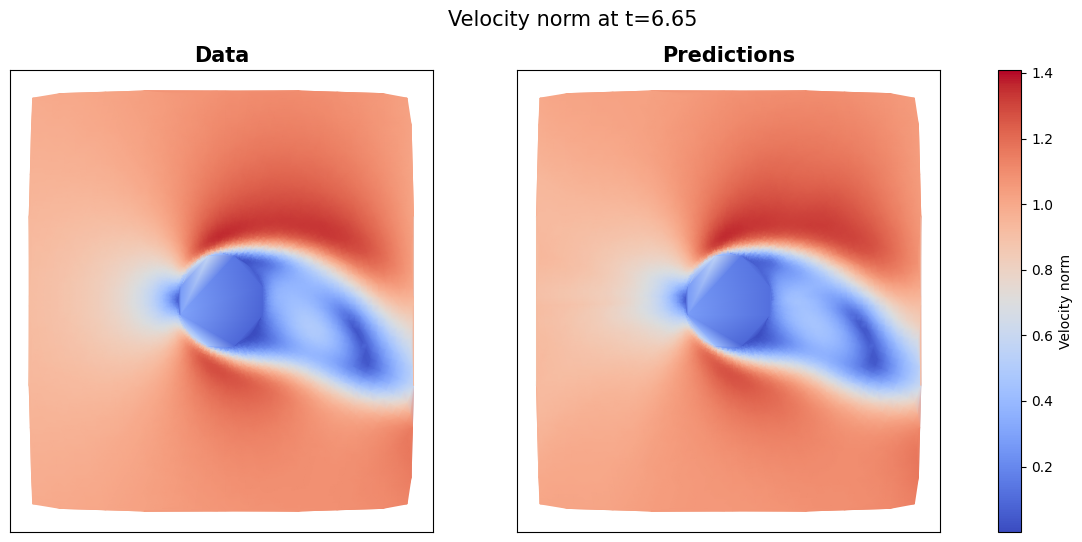

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134


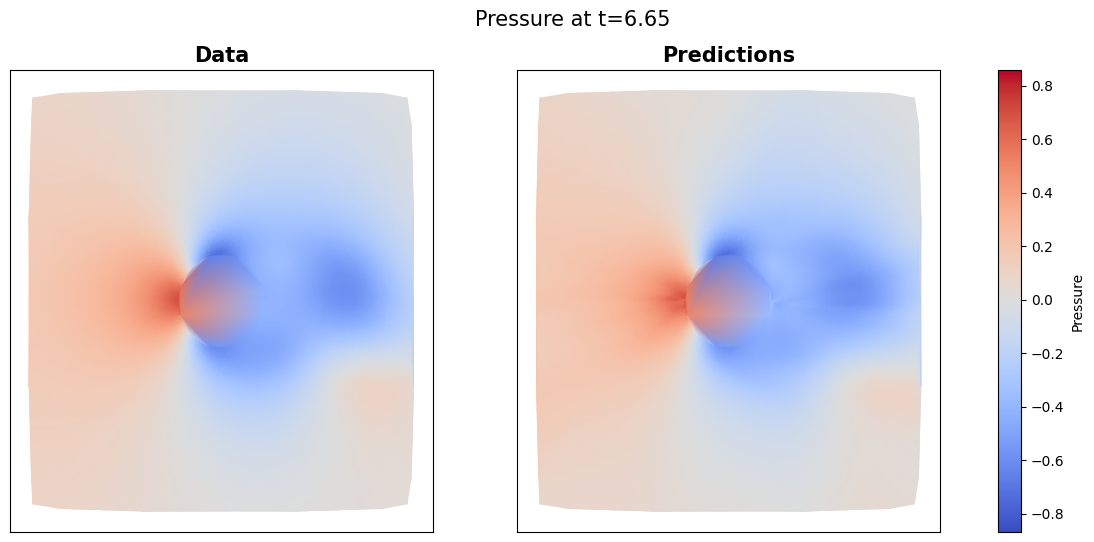

In [9]:
for k in range(1):
    hyper_param['num'] = [num[k]]
    hyper_param['case'] [case[k]]
    hyper_param['H'] = [DICT_CASE[str(k)] for k in hyper_param['case']]
    hyper_param['ya0'] = [DICT_Y0[str(k)] for k in hyper_param['num']]
    hyper_param['file'] = [
        f"model_{num_}_case_{case_}.csv" for num_, case_ in zip(hyper_param['num'], hyper_param['case'])
        ]
    (
        X_full,
        U_full,
    ) = charge_data(hyper_param, PARAM_ADIM, mean_std)
    
    U_predict = model(X_full)

    U_predict = U_predict.detach().numpy()
    X_full = X_full.numpy()
    U_full = U_full.numpy()
    x_data = (X_full[:, 0]*mean_std['x_std'] + mean_std['x_mean']) * PARAM_ADIM['L']
    y_data = (X_full[:, 1]*mean_std['y_std'] + mean_std['y_mean']) * PARAM_ADIM['L']
    t_data = (X_full[:, 2]*mean_std['t_std'] + mean_std['t_mean']) * (PARAM_ADIM['L']/PARAM_ADIM['V'])
    u_data = (U_full[:, 0]*mean_std['u_std'] + mean_std['u_mean']) * PARAM_ADIM['V']
    v_data = (U_full[:, 1]*mean_std['v_std'] + mean_std['v_mean']) * PARAM_ADIM['V']
    p_data = (U_full[:, 2]*mean_std['p_std'] + mean_std['p_mean']) * ((PARAM_ADIM["V"] ** 2) * PARAM_ADIM["rho"])
    u_predict = (U_predict[:, 0]*mean_std['u_std'] + mean_std['u_mean']) * PARAM_ADIM['V']
    v_predict = (U_predict[:, 1]*mean_std['v_std'] + mean_std['v_mean']) * PARAM_ADIM['V']
    p_predict = (U_predict[:, 2]*mean_std['p_std'] + mean_std['p_mean']) * ((PARAM_ADIM["V"] ** 2) * PARAM_ADIM["rho"])
    norme_vitesse_data = (u_data**2 + v_data**2)**0.5
    norme_vitesse_predict = (u_predict**2 + v_predict**2)**0.5
    plot_flow(
    x_data,
    y_data,
    t_data,
    norme_vitesse_data,
    norme_vitesse_predict,
    'results/' + folder_name + '/velocity_norm.gif',
    fps=20,
    title="Velocity norm",
    )
    plot_flow(
    x_data,
    y_data,
    t_data,
    p_data,
    p_predict,
    'results/' + folder_name + '/pression.gif',
    fps=20,
    title="Pressure",
    )
    

In [9]:
u_data = (U_full[:, 0]*mean_std['u_std'].item() + mean_std['u_mean'].item()) * PARAM_ADIM['V']


In [28]:
mean_std['u_mean'].item()

0.8194908499717712

In [29]:
mean_std['u_std'].item()

0.3965734541416168

In [30]:
U_full

<function Tensor.numpy>